# Moving From Digits to Fashion:
This notebook will take techniques learned in the previous notebook and apply them to a slightly harder data set: MNIST Fashion.

In [2]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
import numpy as np

from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette(sns.color_palette("Blues_d", n_colors=10, desat=1))

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

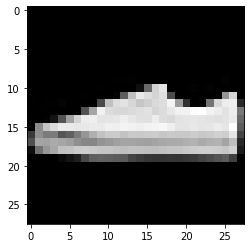

In [4]:
# Load batch and take a look at a sample image:
train_iter = iter(trainloader)
images, labels = train_iter.next()

image_0 = images[0].squeeze().numpy()
plt.imshow(image_0, cmap="Greys_r")

In [51]:
class Network(nn.Sequential):
    
    def __init__(self, layers):
        super().__init__(self.init_modules(layers))

    def init_modules(self, layers):
        """
        Define simple sequence of operations for feed forward based on desired
        layer architecture. 
        """
        n_layers = len(layers)
        modules = OrderedDict()

        # Layer definitions for input and inner layers:
        for i in range(n_layers - 2):
            modules[f'fc{i}']   = nn.Linear(layers[i], layers[i+1])
            modules[f'relu{i}'] = nn.ReLU()

        # Definition for output layer:
        modules['fc_out'] = nn.Linear(layers[-2], layers[-1])
        modules['smax_out'] = nn.LogSoftmax(dim=1)
        
        return modules
    
    def train(self, trainloader, epochs, optimizer=optim.Adam, lr=0.003, criterion=nn.NLLLoss(), plot_loss=False):
        opt = optimizer(self.parameters(), lr=lr)
        epoch_error = []
        for e in range(epochs):
            running_loss = 0
            for x, y in trainloader:
                x = x.view(x.shape[0], -1)
                opt.zero_grad()
                loss = criterion(self(x), y)
                loss.backward()
                opt.step()
                running_loss += loss.item()
            epoch_error.append(running_loss/len(trainloader))
        
        if plot_loss:
            plt.title('Training Loss')
            plt.xlabel('Epochs')
            plt.plot(epoch_error)   

In [52]:
# Define network architecture:
layers = (784, 392, 196, 98, 10)
model = Network(layers)
model

Network(
  (fc0): Linear(in_features=784, out_features=392, bias=True)
  (relu0): ReLU()
  (fc1): Linear(in_features=392, out_features=196, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=196, out_features=98, bias=True)
  (relu2): ReLU()
  (fc_out): Linear(in_features=98, out_features=10, bias=True)
  (smax_out): LogSoftmax()
)

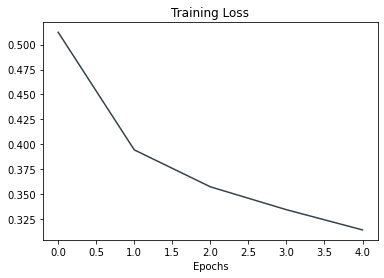

In [53]:
model.train(trainloader, 5, plot_loss=True)

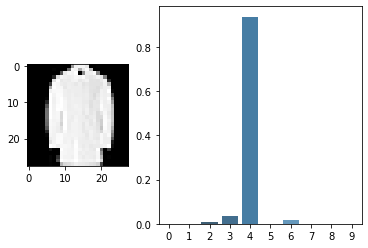

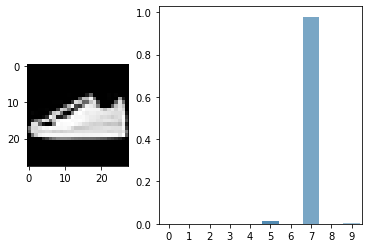

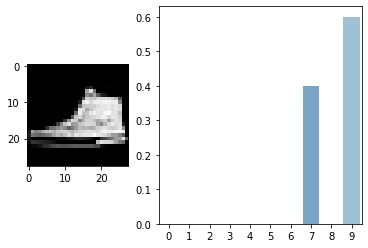

In [54]:
test_images, _ = iter(testloader).next()
 
for img in test_images[0:3]:
    fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,2], 'height_ratios':[1]})
    ps = torch.exp(model(img.view(1, -1)))
    axes[0].imshow(img.numpy().squeeze(), cmap='Greys_r')
    sns.barplot(x=np.arange(10), y=ps.detach().numpy().squeeze(), ax=axes[1])
    plt.show()
